### Tabular-based datasets to predict exon group, spliceAI score or dPSI
This notebook uses the previously built datasets (`4_generateTabularDatasets.ipynb`) to build simple models to predict exon group, spliceAI score or dPSI observed in the paired datasets

In [1]:
import pandas as pd
import numpy as np
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import permutation_test_score
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import glob

In [2]:
# RBPs used in mutsplice analysis
TARGET_RBPS = ['U2AF2', 'TIAL1', 'SF1', 'HNRNPK', 'KHDRBS1', 'HNRNPM',
       'PCBP2', 'RBFOX2', 'FUS', 'DAZAP1', 'SRSF3', 'PCBP1', 'HNRNPU',
       'MATR3', 'KHSRP', 'TARDBP', 'HNRNPLL', 'RBM25', 'CELF1', 'PTBP1',
       'SRSF1', 'HNRNPH1', 'SFPQ', 'HNRNPL', 'SRSF9', 'HNRNPF', 'SRSF7',
       'SRSF5', 'HNRNPA1', 'QKI', 'HNRNPC']
DATA_PATH = "/home/pbarbosa/git_repos/mutsplice/data/3_paired_datasets_tabular_to_ML"
DATASET_TYPES = {'motifs': '_motifs.tsv.gz',
                 'motifs_per_loc': '_motifs_per_loc.tsv.gz',
                 'kmers': '_kmers.tsv.gz'
                 }

### Auxiliar functions

#### Classification

In [ ]:
def dummy_classifier(x: pd.DataFrame, y: pd.Series, tag: str):
    """Dummy classifer to distinguish exon
    group based on sequence-based features"""
    clf = DummyClassifier(strategy="uniform")
    skf = StratifiedKFold(n_splits=5)
    cv_results = cross_validate(
        clf, x, y, scoring="accuracy", cv=skf, return_estimator=True
    )
    accuracies = []

    for i, _ in enumerate(cv_results["estimator"]):
        accuracies.append(cv_results["test_score"][i])

    return round(np.mean(accuracies), 3), None, None, None

In [ ]:
def classifier(x: pd.DataFrame, y: pd.Series, clf_name: str):
    """
    Simple classifiers to distinguish
    exon group based on sequence-based features
    """
    if clf_name == "DecisionTreeClassifier":
        clf = DecisionTreeClassifier(random_state=0, min_samples_leaf=3, max_depth=5)
    elif clf_name == "RandomForestClassifier":
        clf = RandomForestClassifier(n_estimators=10, random_state=0)
    elif clf_name == "LogisticRegressionClassifier":
        clf = LogisticRegression(max_iter=100)  

    skf = StratifiedKFold(n_splits=5)
    cv_results= cross_validate(clf, x, y, scoring='accuracy', cv=skf, return_estimator=True)
    
    _, _, pval = permutation_test_score(clf, x, y, scoring="accuracy", cv=skf, n_permutations=100)
    
    accuracies, feat_import = [],[]
    
    for i, model in enumerate(cv_results['estimator']):
        if hasattr(model, 'feature_importances_'):
            feat_import.append(model.feature_importances_)
        elif hasattr(model, 'coef_'):
            feat_import.append(model.coef_)

        accuracies.append(cv_results['test_score'][i]) 
    return round(np.mean(accuracies), 3), pval, np.array(feat_import).mean(axis=0).tolist(), list(x)

In [ ]:
def run_classification(df: pd.DataFrame, with_len_features=False):
    """
    Train classifiers to distinguish exon group 
    based on sequence-based features
    """
    df = df.copy()
    results = {}
    if not with_len_features:
        len_features = [x for x in df.columns if x.startswith('len_')]
        df = df.drop(len_features, axis=1)
    
    df.set_index('seq_id', inplace=True)
    df.drop('spliceai_pred', axis=1, inplace=True)
    
    # Define the labels
    y = df.exon_group
    df.drop('exon_group', axis=1, inplace=True)

    # Remove features with only 0 values
    df = df.loc[:, (df != 0).any(axis=0)]   

    # Impute NA features with its median value
    df = df.apply(lambda x: x.fillna(x.median()), axis=0)

    for tag, clf in {'DummyClassifier': dummy_classifier,
                     'LogisticRegressionClassifier': classifier,
                     'DecisionTreeClassifier': classifier,
                     'RandomForestClassifier': classifier}.items():
        results[tag] = clf(df, y, tag)
    return results

#### Regression

In [23]:
def dummy_regressor(x: pd.DataFrame, y: pd.Series, tag: str):
    """Dummy regressor to predict spliceAI score
    based on sequence-based features"""

    rgr = DummyRegressor(strategy="mean")
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = cross_validate(
        rgr, x, y, scoring="r2", cv=kf, return_estimator=True
    )
    r2 = []

    for i, _ in enumerate(cv_results["estimator"]):
        r2.append(cv_results["test_score"][i])

    return round(np.mean(r2), 3), None, None, None

In [24]:
def regressor(x: pd.DataFrame, y: pd.Series, rgr_name: str):
    """
    Simple regressors to predict spliceAI score
    based on sequence-based features
    """
    if rgr_name == "LassoRegressor":
        rgr = Lasso(alpha=1)
    elif rgr_name == "RidgeRegressor":
        rgr = Ridge(alpha=1)
    elif rgr_name == "RandomForestRegressor":
        rgr = RandomForestRegressor(n_estimators=10, random_state=0)
                  
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_results= cross_validate(rgr, x, y, scoring='r2', cv=kf, return_estimator=True)
    
    _, _, pval = permutation_test_score(rgr, x, y, scoring="r2", cv=kf, n_permutations=100)
    
    r2, feat_import = [],[]
    
    for i, model in enumerate(cv_results['estimator']):
        if hasattr(model, 'feature_importances_'):
            feat_import.append(model.feature_importances_)
        elif hasattr(model, 'coef_'):
            feat_import.append(model.coef_)
            
        r2.append(cv_results['test_score'][i]) 
    return round(np.mean(r2), 3), pval, np.array(feat_import).mean(axis=0).tolist(), list(x)

In [162]:
def run_regression(df: pd.DataFrame, with_len_features=False):
    """
    Train regressor to predict SpliceAI score
    based on sequence-based features
    """
    df = df.copy()
    results = {}
    if not with_len_features:
        len_features = [x for x in df.columns if x.startswith('len_')]
        df = df.drop(len_features, axis=1)
    
    df.set_index('seq_id', inplace=True)
    df.drop('exon_group', axis=1, inplace=True)
    
    # Define the labels
    y = np.array(df.spliceai_pred)
    df.drop('spliceai_pred', axis=1, inplace=True)

    # Remove features with only 0 values
    df = df.loc[:, (df != 0).any(axis=0)]   

    # Impute NA features with its median value
    df = df.apply(lambda x: x.fillna(x.median()), axis=0)

    for tag, rgr in {'DummyRegressor': dummy_regressor,
                     'RidgeRegressor':regressor,
                     'RandomForestRegressor': regressor,
                     }.items():
        results[tag] = rgr(df, y, tag)
    return results

### Train classifiers and regressors

In [ ]:
cols_to_drop = ["target_coordinates", "rbp_name", "dPSI"]
out_cols = ["rbp_name", "dataset_type", "model", "score", "pval", "feat_import", "features"]

for rbp in TARGET_RBPS:
    print(rbp)
    out = []
    for dataset_type, dataset_suffix in DATASET_TYPES.items():
        print(dataset_type)
        data = pd.read_csv(f"{DATA_PATH}/{rbp}{dataset_suffix}", sep="\t")
        data = data[data.rbp_name == rbp].drop(columns=cols_to_drop)
        results = run_classification(data, with_len_features=False)
        for _clf, res in results.items():
            out.append([rbp, dataset_type, _clf, *res])
        
        results = run_regression(data, with_len_features=False)
        for _rgr, res in results.items():
            out.append([rbp + f" (N={data.shape[0]})", dataset_type, _rgr, *res])
    out_df = pd.DataFrame(out, columns=out_cols)
    out_df.to_csv(f"5_ml_results/5_results_{rbp}.csv", index=False)

### Evaluation

In [164]:
files = glob.glob('5_ml_results/5_results*.csv')
df = pd.concat([pd.read_csv(f) for f in files])

Add dataset counts for all RBP names

In [165]:
dt_size = df.copy()
dt_size['dt_size'] = dt_size.rbp_name.str.split(" ", expand=True)[1]
dt_size['rbp_name'] = dt_size.rbp_name.str.split(" ", expand=True)[0]
dt_size = dt_size.dropna(subset=['dt_size'])
dt_size = dt_size[['rbp_name', 'dt_size']].drop_duplicates()
dt_size['rbp_name_new'] = dt_size.rbp_name + " " + dt_size.dt_size
dt_size.drop('dt_size', axis=1, inplace=True)
df['rbp_name'] = df.rbp_name.str.split(" ", expand=True)[0]
df = df.merge(dt_size, on='rbp_name', how='left')
df['rbp_name'] = df.rbp_name_new
df.dropna(subset=['rbp_name'], inplace=True)

#### Classification

In [166]:
df_clf = df[df.model.str.contains('Classifier')].copy()

In [167]:
df_clf.loc[df_clf['score'].idxmax()]

rbp_name                   HNRNPM (N=266)
dataset_type                 Gapped_Kmers
model           NonLineargkmSVMClassifier
score                            0.642857
pval                                  NaN
feat_import                           NaN
features                              NaN
rbp_name_new               HNRNPM (N=266)
Name: 51, dtype: object

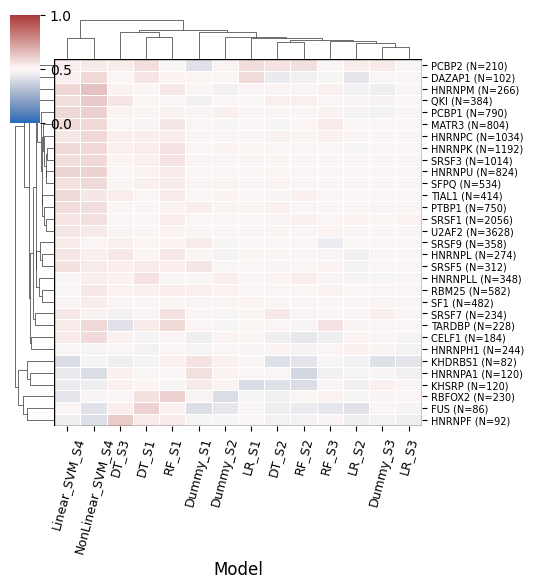

In [146]:
df_clf['clf_id'] = df_clf['model'] + '_' + df_clf['dataset_type']

rename_ids = {'DummyClassifier_motifs': 'Dummy_S1', 
              'LogisticRegressionClassifier_motifs': 'LR_S1', 
              'DecisionTreeClassifier_motifs': 'DT_S1', 
              'RandomForestClassifier_motifs': 'RF_S1',
              'DummyClassifier_motifs_per_loc': 'Dummy_S2', 
              'LogisticRegressionClassifier_motifs_per_loc': 'LR_S2', 
              'DecisionTreeClassifier_motifs_per_loc': 'DT_S2', 
              'RandomForestClassifier_motifs_per_loc': 'RF_S2',
              'DummyClassifier_kmers': 'Dummy_S3',
              'LogisticRegressionClassifier_kmers': 'LR_S3',
              'DecisionTreeClassifier_kmers': 'DT_S3',
              'RandomForestClassifier_kmers': 'RF_S3',
              'LineargkmSVMClassifier_Gapped_Kmers': 'Linear_SVM_S4',
              'NonLineargkmSVMClassifier_Gapped_Kmers': 'NonLinear_SVM_S4'}
              
df_clf['clf_id'] = df_clf['clf_id'].replace(rename_ids)

clf_heat = df_clf.drop(columns=['feat_import', 'features', 'pval', 'model', 'dataset_type']).pivot(index='rbp_name', columns='clf_id', values='score')
g = sns.clustermap(data=clf_heat, cmap="vlag", figsize=(6, 6), center=0.5, yticklabels=True, vmin=0, vmax=1, dendrogram_ratio=0.1, linewidths=0.5)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize=9, rotation=75)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize=7)
g.ax_heatmap.set_xlabel('Model', fontsize=12)
g.ax_heatmap.set_ylabel('');
rect = patches.Rectangle((0, 0), len(clf_heat.columns), len(clf_heat.index), linewidth=1, edgecolor='black', facecolor='none')
ax = g.ax_heatmap
ax.add_patch(rect)
plt.savefig('plots/4_ml_classification.pdf')

#### Regression

In [155]:
df_rgr = df[~df.model.str.contains('Classifier')].copy()

In [160]:
df_rgr.loc[df_rgr['score'].idxmax()]

rbp_name              HNRNPK (N=1192)
dataset_type             Gapped_Kmers
model           LineargkmSVMRegressor
score                        0.138441
pval                              NaN
feat_import                       NaN
features                          NaN
rbp_name_new          HNRNPK (N=1192)
rgr_id                  Linear_SVM_S4
Name: 188, dtype: object

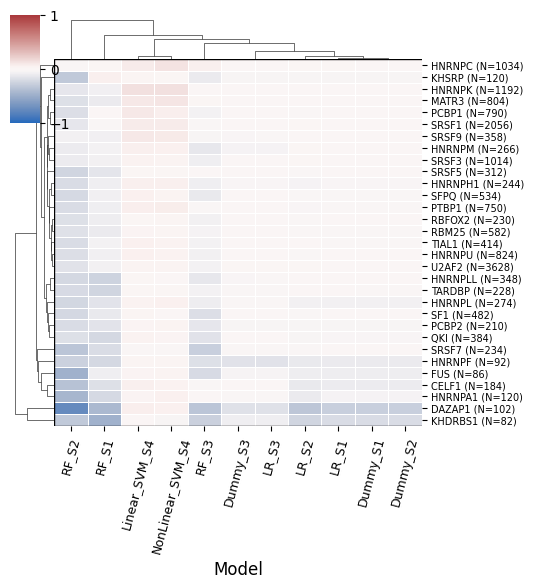

In [156]:
df_rgr['rgr_id'] = df_rgr['model'] + '_' + df_rgr['dataset_type']

rename_ids = {'DummyRegressor_motifs': 'Dummy_S1', 
              'RidgeRegressor_motifs': 'LR_S1',
              'RandomForestRegressor_motifs': 'RF_S1',
              'DummyRegressor_motifs_per_loc': 'Dummy_S2', 
              'RidgeRegressor_motifs_per_loc': 'LR_S2', 
              'RandomForestRegressor_motifs_per_loc': 'RF_S2',
              'DummyRegressor_kmers': 'Dummy_S3',
              'RidgeRegressor_kmers': 'LR_S3',
              'RandomForestRegressor_kmers': 'RF_S3',
              'LineargkmSVMRegressor_Gapped_Kmers': 'Linear_SVM_S4',
              'NonLineargkmSVMRegressor_Gapped_Kmers': 'NonLinear_SVM_S4'}
df_rgr['rgr_id'] = df_rgr['rgr_id'].replace(rename_ids)

rgr_heat = df_rgr.drop(columns=['feat_import', 'features', 'pval', 'model', 'dataset_type']).pivot(index='rbp_name', columns='rgr_id', values='score')
g = sns.clustermap(data=rgr_heat, cmap="vlag", figsize=(6, 6), center=0, yticklabels=True, vmin=-1, vmax=1, dendrogram_ratio=0.1, linewidths=0.5)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize=9, rotation=75)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize=7)
g.ax_heatmap.set_xlabel('Model', fontsize=12)
g.ax_heatmap.set_ylabel('');
rect = patches.Rectangle((0, 0), len(clf_heat.columns), len(clf_heat.index), linewidth=1, edgecolor='black', facecolor='none')
ax = g.ax_heatmap
ax.add_patch(rect)
plt.savefig('plots/4_ml_regression.pdf')